In [35]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os

In [36]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the .npy file
X = np.load('/content/drive/MyDrive/Colab Notebooks/x_letters.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/y_letters.npy')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Converting data to respectively float32 and int64
X = X.astype(np.float32)
y = y.astype(np.int64)

y = keras.utils.to_categorical(y, 26)
n_classes = y.shape[1]

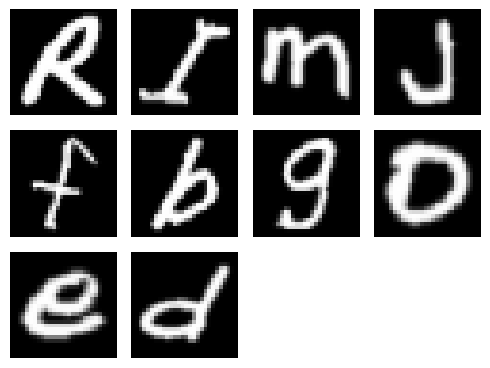

In [38]:
#Lets check how the handwritten letters look like in the dataset

def plot_sample_letters(X, num_samples):

    plt.figure(figsize=(5, 5))
    indices = np.random.choice(len(X), num_samples, replace=False)  # Randomly select indices
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')  # Reshape and plot the letter
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

# Call the function to plot sample letters
plot_sample_letters(X, num_samples=10)

In [39]:
X.shape, y.shape

((88799, 28, 28), (88799, 26))

In [40]:
batch_size = 32
latent_dim = 32

In [41]:
# We are combining X and y into singular tensorflow dataset
# because the data is ordered (all examples of 0, then all examples of 1, etc.), we need to shuffle it, so our splits contain all classes
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(64)

In [42]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        # Initialize lists to store loss values
        self.d_loss_history = []
        self.g_loss_history = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):

        # Custom training loop for a single step of training the GAN.
        # Unpack the real images and corresponding classes from the input data.

        real_images, real_classes = data
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Generate fake images from the random latent vectors and real classes.
        generated_images = self.generator([random_latent_vectors, real_classes])

        # Combine the generated images with the real images for discriminator training.
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        combined_classes = ops.concatenate([real_classes, real_classes], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        #Added noise makes sure the discriminator is not perfect, so that the generator never has a chance to learn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_classes])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Assemble misleading labels for generator training
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (without updating the discriminator)
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, real_classes])
            predictions = self.discriminator([generated_images, real_classes])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Store the loss values for plotting later
        self.d_loss_history.append(self.d_loss_metric.result().numpy())
        self.g_loss_history.append(self.g_loss_metric.result().numpy())
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def plot_loss_history(self):
        # Plot the evolution of D-Loss and G-Loss
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_loss_history, label="D-Loss")
        plt.plot(self.g_loss_history, label="G-Loss")
        plt.title("D-Loss and G-Loss over epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [43]:
def build_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(n_classes,))

    #noise and label inputs are concatenated together
    #this allows to produce a variety of images based on the given labels
    x = layers.Concatenate(axis=-1)([noise_input, label_input])

    x = layers.Dense(100, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
    #Sigmoid as to avoid Loss on the Determinator due to the dataset being black and white
    x = layers.Dense(28*28, activation="sigmoid")(x)
    output = layers.Reshape((28, 28))(x)

    return keras.Model([noise_input, label_input], output, name="generator")

def build_discriminator():
    image_input = keras.Input(shape=(28, 28))
    label_input = keras.Input(shape=(n_classes,))

    #flattening the image input to transform the 2D data into 1D vector, making it suitable for connected layers
    x = layers.Flatten()(image_input)

    #Concatenation allows to use both image and class to make predictions
    x = layers.Concatenate(axis=-1)([x, label_input])
    x = layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dense(100, activation="relu", kernel_initializer="he_normal")(x)

    #using sigmoid activation produces a value between 0 and 1, that indicates the probability of the
    #input being fake (0) or real image (1)
    output = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model([image_input, label_input], output, name="discriminator")


In [44]:
generator = build_generator()
discriminator = build_discriminator()

epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [45]:
tf.config.run_functions_eagerly(True)
gan.fit(dataset, epochs=epochs)

Epoch 1/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 164s 118ms/step - d_loss: 0.6309 - g_loss: 1.7859
Epoch 2/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 161s 116ms/step - d_loss: 0.5398 - g_loss: 1.7069
Epoch 3/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 204s 117ms/step - d_loss: 0.4843 - g_loss: 1.7611
Epoch 4/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 201s 117ms/step - d_loss: 0.4468 - g_loss: 1.9721
Epoch 5/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 203s 118ms/step - d_loss: 0.4402 - g_loss: 2.0185
Epoch 6/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 163s 118ms/step - d_loss: 0.4250 - g_loss: 2.0801
Epoch 7/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 202s 118ms/step - d_loss: 0.4180 - g_loss: 2.1373
Epoch 8/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 205s 120ms/step - d_loss: 0.4065 - g_loss: 2.2699
Epoch 9/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 202s 120ms/step - d_loss: 0.4089 - g_loss: 2.2021
Epoch 10/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 199s 119ms/step - d_loss: 0.4000 - g_loss: 2.2422
Epoch 11/30
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 170s 122ms/step - d_loss: 0.3982 - g

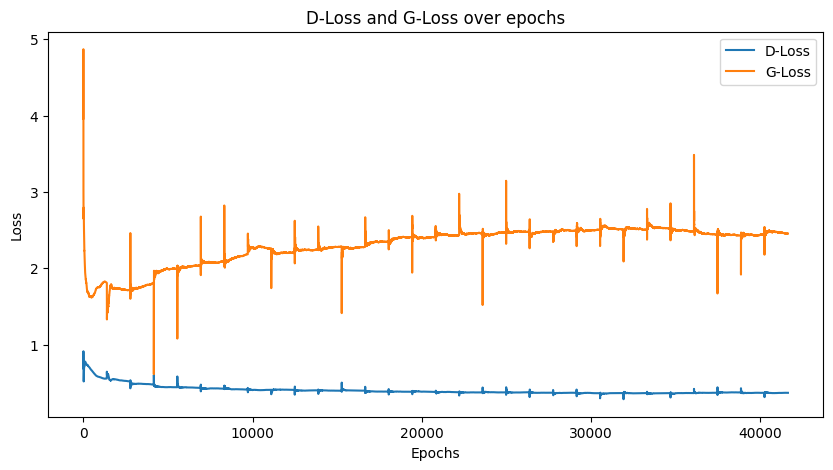

In [46]:
# After training, you can plot the loss history:
gan.plot_loss_history()

In [47]:
MAPPING_TABLE = {chr(i + 97): i for i in range(26)}  # Creates a mapping from 'a' to 'z' to 0-25

def generate_letter(letter):
    # Get the mapped index for the letter
    mapped_letter = MAPPING_TABLE[letter]

    # Generate random latent vector and one-hot label
    random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
    one_hot_label = tf.one_hot(mapped_letter, depth=len(MAPPING_TABLE))  # Using len(MAPPING_TABLE) for number of classes

    # Generate images using the generator
    generated_images = gan.generator([random_latent_vectors, one_hot_label[tf.newaxis]])  # tf.newaxis adds an extra dimension
    return generated_images[0].numpy()  # Return the generated image as a numpy array


In [48]:
def plot_string(word):

  fig, ax = plt.subplots(1, len(word), figsize=(len(word)*2, 2))
  for i in range(len(word)):
    generated_letter = generate_letter(word[i])
    ax[i].imshow(generated_letter, cmap='gray')
    ax[i].axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

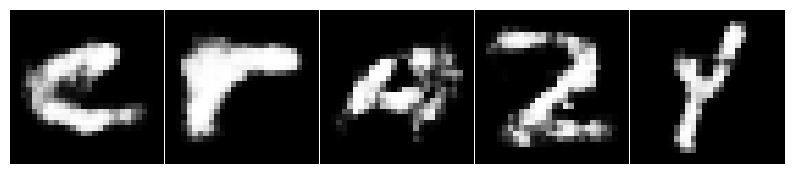

In [49]:
plot_string("crazy")

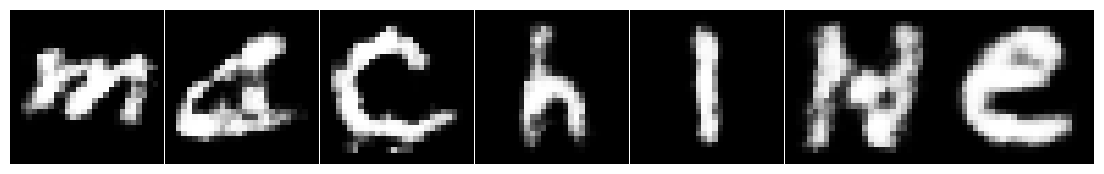

In [58]:
plot_string("machine")